In [13]:
from datasets import load_from_disk
my_dataset = load_from_disk("/home/UNT/ap1923/ap1923/betterDeliberation/src/deliberation/storedDeliberations/context110/new110/my_hf_dataset_new110")
my_dataset["train"][0]

{'models_used': ['meta-llama/Llama-3. 1-70B-Instruct'],
 'rounds': 2,
 'number_of_agents': 3,
 'problem': 'You are given the following symptoms joint_pain, skin_peeling, silver_like_dusting, small_dents_in_nails, inflammatory_nails. Your task is to diagnose a disease that best matches the symptoms.',
 'gold_diagnosis': 'Psoriasis',
 'conversation_id': 803,
 'history_current': "Both responses accurately diagnose the condition as Psoriasis based on the provided symptoms. However, Response 2 provides a clearer explanation of each symptom's relevance to Psoriasis, making it a more comprehensive and informative answer. A definitive diagnosis by a dermatologist is still necessary for confirmation.",
 'history_neighbour': 'Both responses suggest psoriasis as the likely diagnosis, and they are consistent in their descriptions of the characteristic symptoms. However, Response 1 provides a clearer explanation of the underlying cause of psoriasis, describing it as an autoimmune condition that cau

In [14]:
my_dataset

DatasetDict({
    train: Dataset({
        features: ['models_used', 'rounds', 'number_of_agents', 'problem', 'gold_diagnosis', 'conversation_id', 'history_current', 'history_neighbour', 'reply'],
        num_rows: 5827
    })
    validation: Dataset({
        features: ['models_used', 'rounds', 'number_of_agents', 'problem', 'gold_diagnosis', 'conversation_id', 'history_current', 'history_neighbour', 'reply'],
        num_rows: 728
    })
    test: Dataset({
        features: ['models_used', 'rounds', 'number_of_agents', 'problem', 'gold_diagnosis', 'conversation_id', 'history_current', 'history_neighbour', 'reply'],
        num_rows: 729
    })
})

In [15]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilgpt2")
tokenizer.pad_token = tokenizer.eos_token
# meta-llama/Llama-3.1-8B-Instruct
# meta-llama/Llama-3.2-1B

In [16]:
def preprocess_function(examples):
    combined_inputs = [
        f"{p} {hc} {hn} {r}"
        for p, hc, hn, r in zip(
            examples["problem"],
            examples["history_current"],
            examples["history_neighbour"],
            examples["reply"],
        )
    ]
    return tokenizer(combined_inputs, truncation=True, padding="max_length")

In [17]:
tokenized_data = my_dataset.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns= my_dataset["train"].column_names,
)

Map (num_proc=4):   0%|          | 0/5827 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/728 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/729 [00:00<?, ? examples/s]

In [18]:
block_size = 128


def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of block_size.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

lm_dataset = tokenized_data.map(group_texts, batched=True, num_proc=4)

Map (num_proc=4):   0%|          | 0/5827 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/728 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/729 [00:00<?, ? examples/s]

In [32]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [33]:
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer
model = AutoModelForCausalLM.from_pretrained("distilbert/distilgpt2")
model_untouched = AutoModelForCausalLM.from_pretrained("distilbert/distilgpt2")

In [ ]:
# training_args = TrainingArguments(
#     output_dir="finetunedDistilledBert_model",
#     eval_strategy="epoch",
#     learning_rate=2e-5,
#     weight_decay=0.01,
#     push_to_hub=False,
# )
training_args = TrainingArguments(
    output_dir="finetunedDistilledBert_model",
    eval_strategy="steps",   
    logging_strategy="steps",
    logging_steps=50,         
    eval_steps=100,           
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=False,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

trainer.train()
# trainer.save_model("finetunedDistilledBert_model")
# tokenizer.save_pretrained("finetunedDistilledBert_model")

/tmp/ipykernel_422631/2258974919.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
100,2.605200,2.337806
200,2.220700,2.065490
300,2.050600,1.924704
400,2.074900,1.831886
500,1.935700,1.757461
600,1.864300,1.703132
700,1.739400,1.656670
800,1.704900,1.609216
900,1.733400,1.578777
1000,1.719000,1.543756


TrainOutput(global_step=17481, training_loss=1.1725701776769326, metrics={'train_runtime': 1823.6343, 'train_samples_per_second': 76.686, 'train_steps_per_second': 9.586, 'total_flos': 4567728497098752.0, 'train_loss': 1.1725701776769326, 'epoch': 3.0})

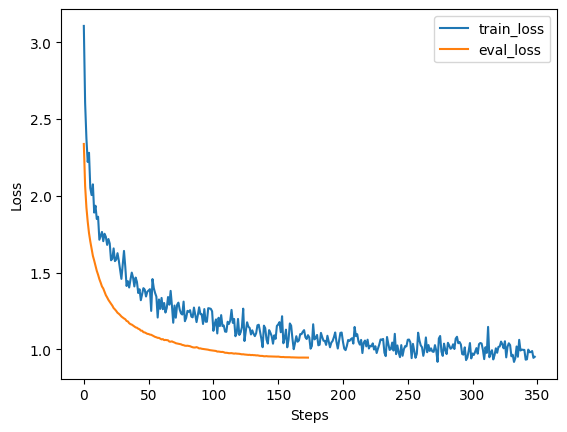

In [36]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history
train_loss = [x["loss"] for x in logs if "loss" in x]
eval_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]

plt.plot(train_loss, label="train_loss")
plt.plot(eval_loss, label="eval_loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
import math

eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 2.58


In [23]:
untouched_trainer = Trainer(
    model=model_untouched,
    args=training_args,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)
eval_results = untouched_trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

/tmp/ipykernel_422631/3312912539.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  untouched_trainer = Trainer(


Perplexity: 31.40


In [28]:
prompt = "What will be the most likely disease diagnosis for a patient showing the following symptoms: continous sneezing, chills and watering of the eye"
# using conversation_id 11 and the gold diagnosis is allergy
prompt_two = "You are given the following symptoms: continous sneezing, chills and watering of the eye. Your task is to diagnose a disease that best matches the symptoms."
from transformers import pipeline

generator = pipeline("text-generation", model="finetunedDistilledBert_model")
print('prompt1 result', generator(prompt))
print('prompt2 result', generator(prompt_two))

generator_two = pipeline("text-generation", model=model_untouched, tokenizer=tokenizer)
print('prompt1 result from untouched model', generator_two(prompt))
print('prompt2 result from untouched model', generator_two(prompt_two))



Device set to use cuda:0
Device set to use cuda:0


prompt1 result [{'generated_text': 'What will be the most likely disease diagnosis for a patient showing the following symptoms: continous sneezing, chills and watering of the eye. Impetigo is a highly contagious bacterial skin infection that typically causes red sores, black sores'}]
prompt2 result [{'generated_text': 'You are given the following symptoms: continous sneezing, chills and watering of the eye. Your task is to diagnose a disease that best matches the symptoms. Both responses accurately diagnose the condition as Allergic Rhinitis based on the provided'}]
prompt1 result from untouched model [{'generated_text': 'What will be the most likely disease diagnosis for a patient showing the following symptoms: continous sneezing, chills and watering of the eye, cough, and diarrhea.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'}]
prompt2 result from untouched model [{'generated_text': 'You are given the following symptoms: continous sneezing, chills and watering of the eye. Your task is to diagnos

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
model_path = "/home/UNT/ap1923/ap1923/modelfinetuning/finetunedDistilledBert_model"
# tokenizer = AutoTokenizer.from_pretrained(model_path)
model_three = AutoModelForCausalLM.from_pretrained(model_path)

device = model_three.device
inputs = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
outputs = model_three.generate(inputs, max_new_tokens=100, do_sample=True, top_k=50, top_p=0.95)
print('fine tuned model result', tokenizer.batch_decode(outputs, skip_special_tokens=True))

# same thing but from untouched model
device = model_untouched.device
inputs = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
outputs = model_untouched.generate(inputs, max_new_tokens=100, do_sample=True, top_k=50, top_p=0.95)
tokenizer.batch_decode(outputs, skip_special_tokens=True)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


fine tuned model result ['What will be the most likely disease diagnosis for a patient showing the following symptoms: continous sneezing, chills and watering of the eye A medical professional would diagnose the condition as Influenza (Flu). The combination of symptoms such as continuous sneezing, chills, watering from the eyes, and watering from the eyes suggest an upper respiratory tract infection. It is essential to consult a healthcare professional for a definitive diagnosis and appropriate treatment. Based on the symptoms provided, the disease diagnosis is likely Influenza (Flu). The combination of symptoms such as continuous sneezing, chills, and watering of the eyes strongly suggests Influ']


['What will be the most likely disease diagnosis for a patient showing the following symptoms: continous sneezing, chills and watering of the eye, mouth, nose, eyes, back, chest, and chest — those who have a high risk of developing an infection or a disease such as flu, flu, or a few more types of pneumonia.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n']

In [29]:
from huggingface_hub import notebook_login
notebook_login()

In [38]:
from datasets import load_from_disk
my_dataset = load_from_disk("/home/UNT/ap1923/ap1923/betterDeliberation/src/deliberation/storedDeliberations/untrainedconv")
my_dataset.push_to_hub("apurbapokharel/untraineddistillgptconversation")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.


CommitInfo(commit_url='https://huggingface.co/datasets/apurbapokharel/untraineddistillgptconversation/commit/3d85b92be9043a83f7d6ddd94dcb8f2c9a5c81ab', commit_message='Upload dataset', commit_description='', oid='3d85b92be9043a83f7d6ddd94dcb8f2c9a5c81ab', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/apurbapokharel/untraineddistillgptconversation', endpoint='https://huggingface.co', repo_type='dataset', repo_id='apurbapokharel/untraineddistillgptconversation'), pr_revision=None, pr_num=None)